In [8]:
include("preamble.jl")

/Users/anguslewis/Documents/SFFMProject/DFQExamples.jl/notebooks


  Activating environment at `~/Documents/SFFMProject/DFQExamples.jl/Project.toml`


   Resolving package versions...


  No Changes to `~/Documents/SFFMProject/DFQExamples.jl/Project.toml`
  No Changes to `~/Documents/SFFMProject/DFQExamples.jl/Manifest.toml`


Plots.GRBackend()

In [9]:
T = Matrix([0.0]')
c = [1.0]
model = FluidQueue(T,c)

nodes = collect(0.0:1:5);

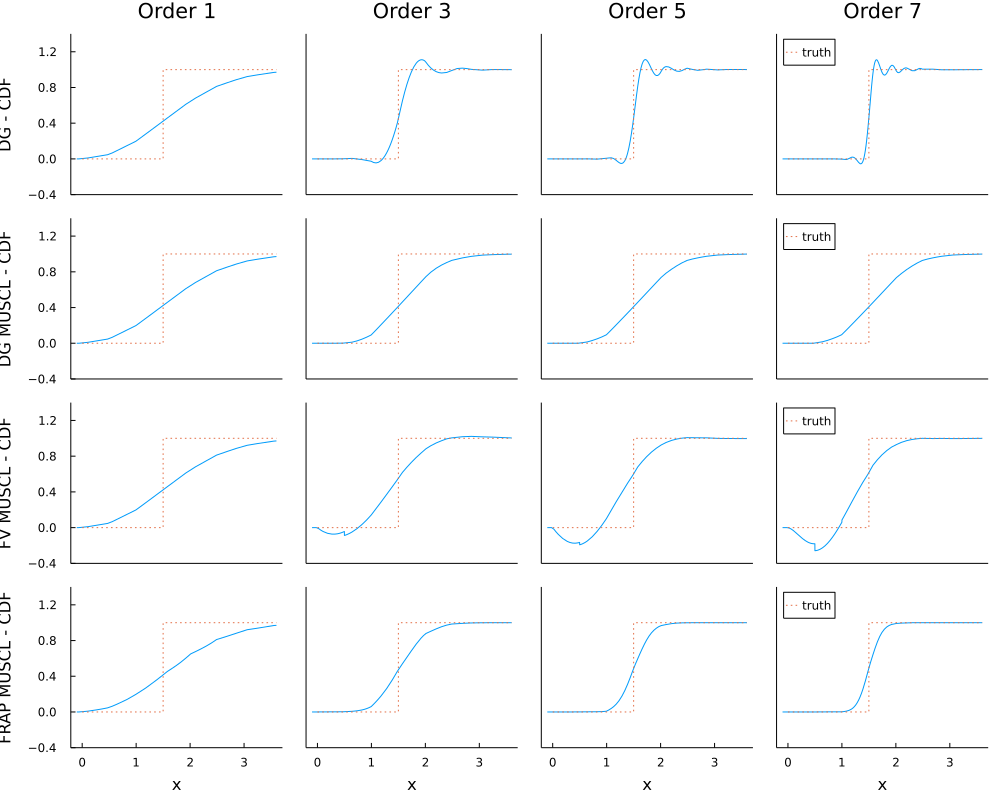

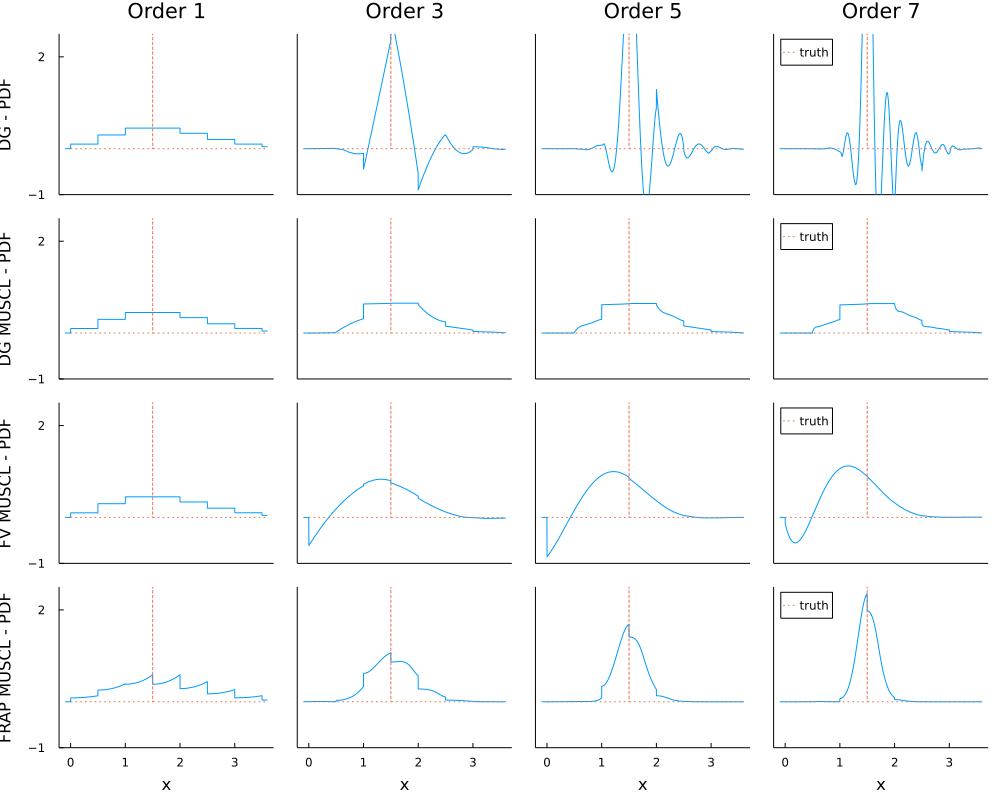

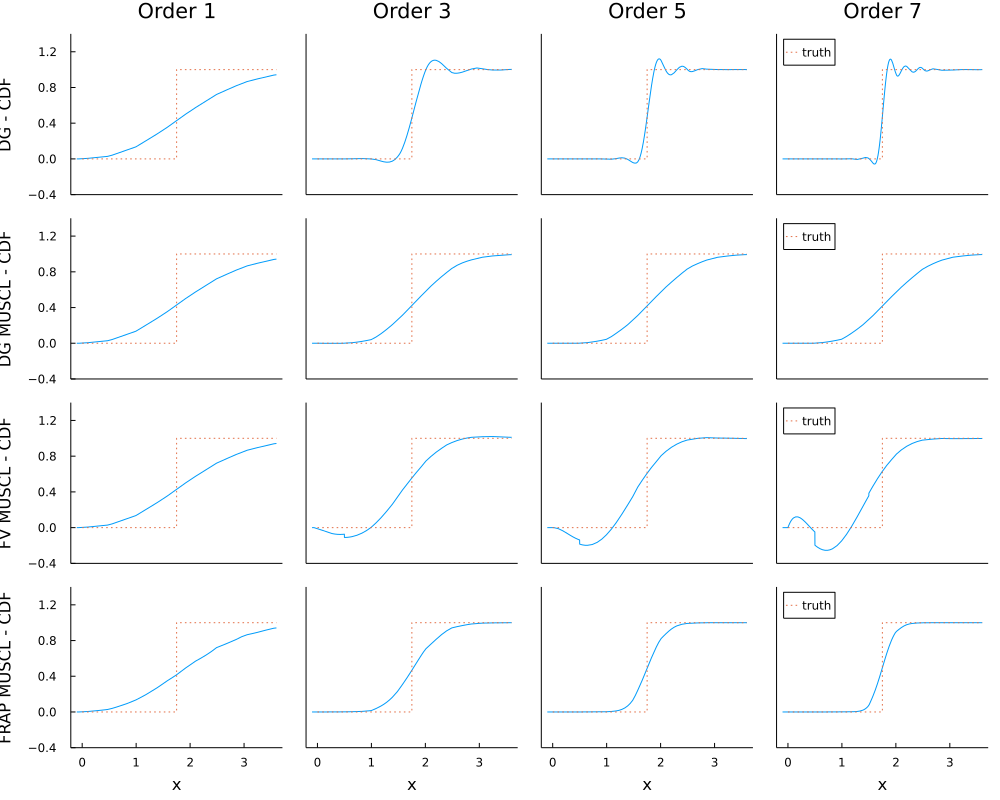

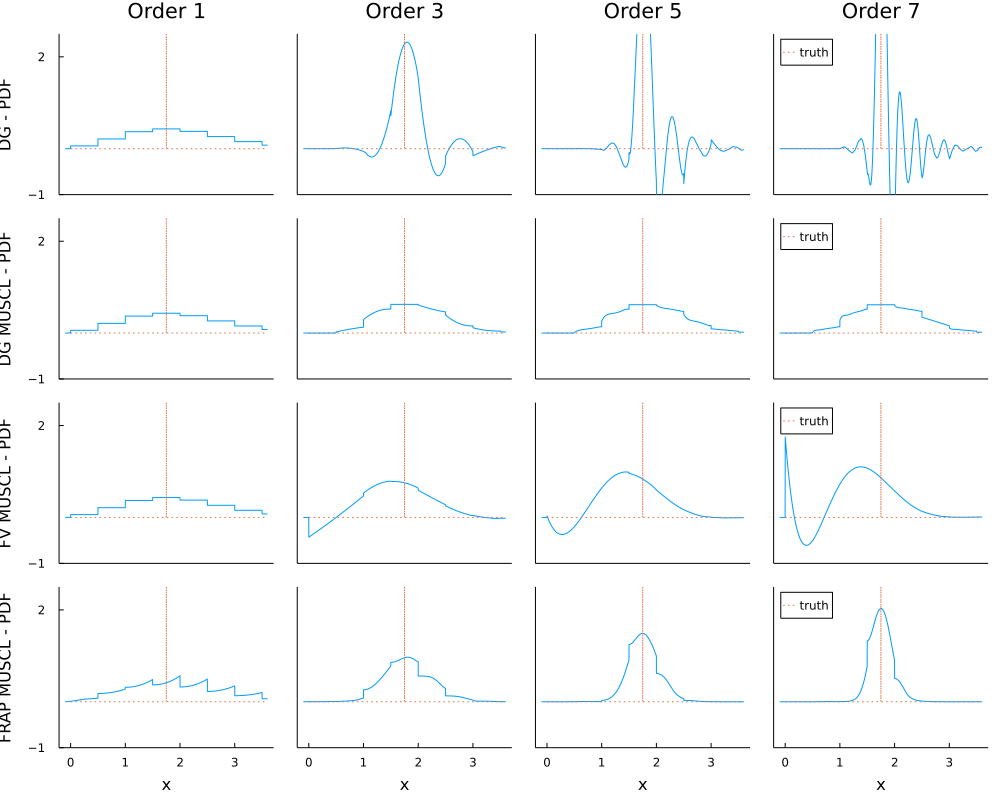

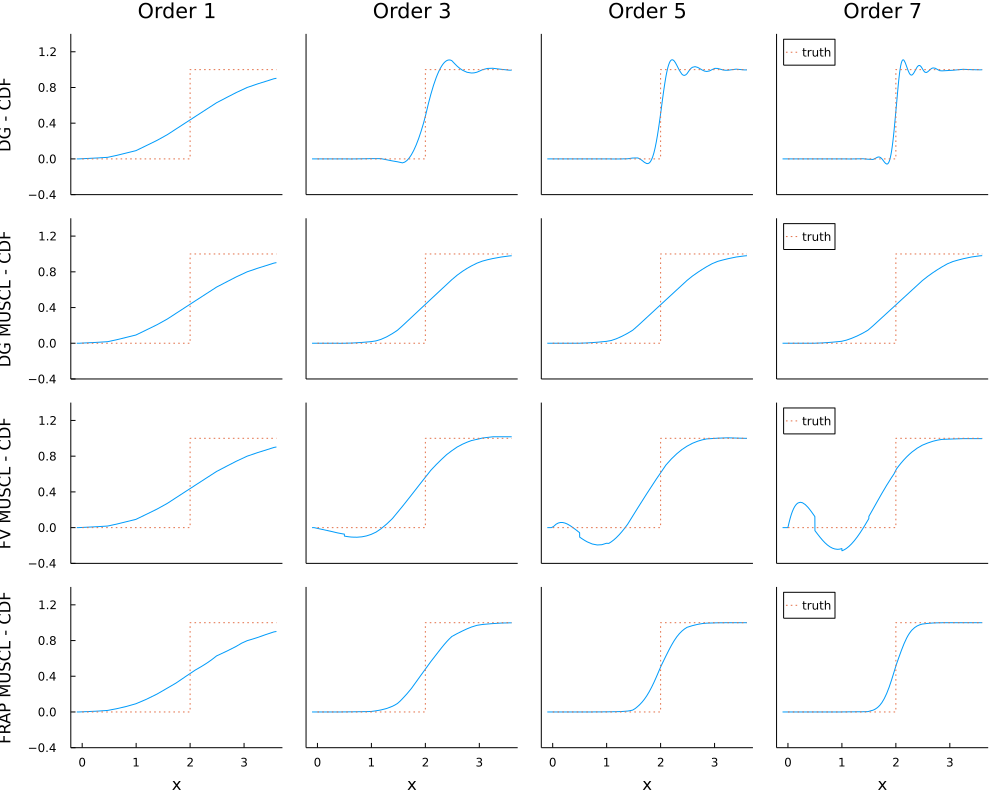

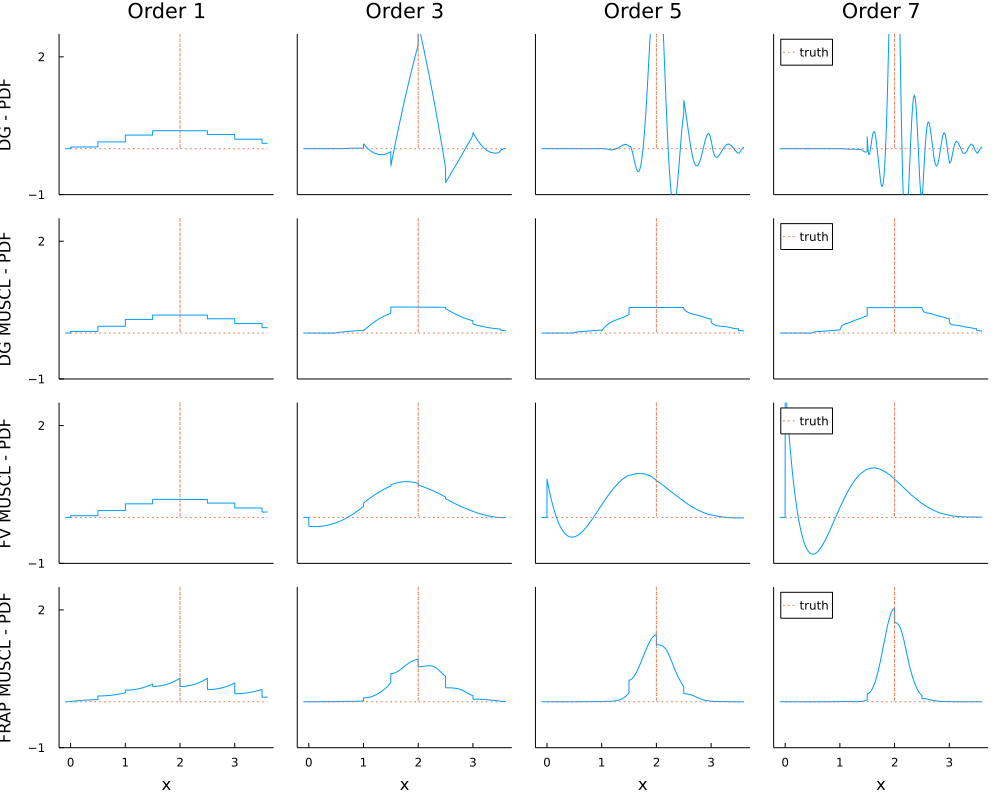

In [44]:

for t in [1.5+sqrt(eps()), 1.75, 2.0-sqrt(eps())]
    for plt_type in (cdf,pdf)
        p = plot(layout=(4,4),size=(1000,800))
        linetypes = [:solid,:solid,:solid,:solid]
        c_order = 0
        for order in 1:2:7
            c_order += 1
            c_mesh = 0
            c_dg = 0
            for mtype in (DGMesh, DGMesh, FVMesh, FRAPMesh)
                c_mesh += 1
                c_dg += 1
                mesh = mtype(nodes,order)

                dq = DiscretisedFluidQueue(model,mesh)
                B = build_full_generator(dq)

                d0 = interior_point_mass(eps(),1,dq)
                dt = ((mtype==DGMesh) && (c_dg==1)) ? (limit_str=" NoLimit ";integrate_time(d0,B,t,StableRK4(0.01); limiter=NoLimiter)) : (limit_str=" ";integrate_time(d0,B,t,StableRK4(0.01)))

                rec = plt_type(dt)
                y_lim_vals = (plt_type==pdf) ? (-1.0,2.5) : (-0.4,1.4)
                y_tick_vals = ((plt_type==pdf) ? (y_lim_vals[1]:3:y_lim_vals[2]) : (y_lim_vals[1]:0.4:y_lim_vals[2]))
                std_plot(args...; kwargs...) = plot!(
                    p.layout.grid[c_mesh,c_order],
                    x->rec(x,1),
                    nodes[1]-0.1, 3.6;
                    ylim=y_lim_vals,
                    linestyle=linetypes[c_mesh],
                    xticks=false,
                    yticks=false,
                    grid=false,
                    kwargs...,
                )
                if c_order == 1
                    std_plot(;label=false,ylabel=uppercase(string(mtype)[1:end-4]*limit_str*"- "*string(plt_type)),legend=false)
                    yticks!(p.layout.grid[c_mesh,c_order], y_tick_vals)
                else
                    std_plot(;label=false,legend=false)
                end
                if c_mesh == 1 
                    plot!(p.layout.grid[c_mesh,c_order]; title="Order "*string(order))
                elseif c_mesh == 4
                    xticks!(p.layout.grid[c_mesh,c_order], 0:1:3.6)
                    plot!(p.layout.grid[c_mesh,c_order]; xlabel="x")
                end
                std_plot2(args... ; kwargs...) = if plt_type==cdf
                    plot!(
                        p.layout.grid[c_mesh,c_order],
                        [0.0;t+eps();t+eps();3.6],
                        [0.0;0.0;1.0;1.0],
                        args...;
                        linestyle=:dot,
                        kwargs...,
                    )
                elseif plt_type==pdf
                    plot!(
                        p.layout.grid[c_mesh,c_order],
                        [0.0;t;t+eps();t+2*eps();3.6],
                        [0.0;0.0;100;0.0;0.0],
                        args...;
                        subplot=c_order,
                        linestyle=:dot,
                        kwargs...
                    )
                end
                if c_order==4
                    std_plot2(;label="truth",legend=:topleft)
                else
                    std_plot2(;label=false)
                end
            end
        end
        display(p)
    end
end

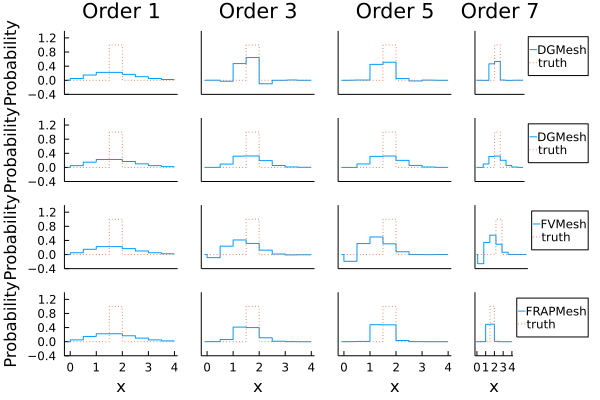

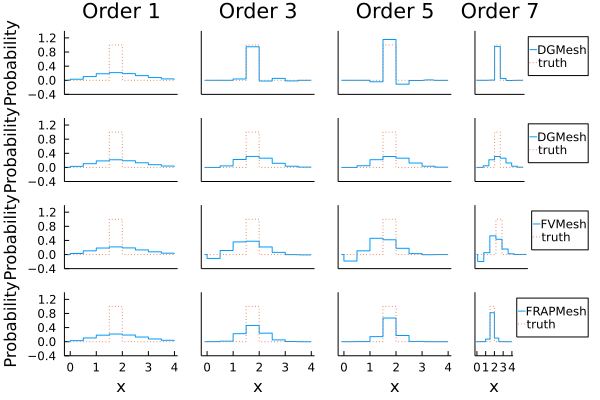

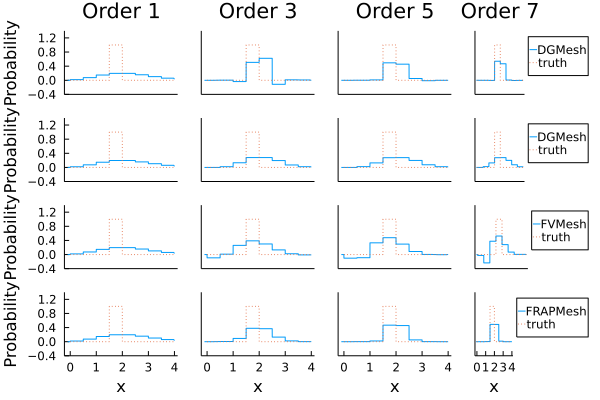

In [21]:

for t in [1.5+sqrt(eps()), 1.75, 2.0-sqrt(eps())]
    p = plot(layout=(4,4),size=(1000,800))
    linetypes = [:solid,:solid,:solid,:solid]
    c_order = 0
    for order in 1:2:7
        c_order += 1
        c_mesh = 0
        c_dg = 0
        for mtype in (DGMesh, DGMesh, FVMesh, FRAPMesh)
            c_mesh += 1
            c_dg += 1
            mesh = mtype(nodes,order)

            dq = DiscretisedFluidQueue(model,mesh)
            B = build_full_generator(dq)

            d0 = interior_point_mass(eps(),1,dq)
            dt = (mtype==DGMesh && c_dg==1) ? integrate_time(d0,B,t,StableRK4(0.01); limiter=NoLimiter) : integrate_time(d0,B,t,StableRK4(0.01))

            rec = cell_probs(dt)
            y_lim_vals = (-0.4,1.4)
            y_tick_vals = (y_lim_vals[1]:0.4:y_lim_vals[2])
            std_plot(args...; kwargs...) = plot!(
                p.layout.grid[c_mesh,c_order],
                x->rec(x,1),
                nodes[1]-0.1, 4.0;
                ylim=y_lim_vals,
                linestyle=linetypes[c_mesh],
                xticks=false,
                yticks=false,
                grid=false,
                kwargs...,
            )
            if c_order == 1
                std_plot(;label=false,ylabel="Probability",legend=false)
                yticks!(p.layout.grid[c_mesh,c_order], y_tick_vals)
            elseif c_order == 4
                std_plot(;label=string(mtype),legend=:outerright)
            else
                std_plot(;label=false,legend=false)
            end
            if c_mesh == 1 
                plot!(p.layout.grid[c_mesh,c_order]; title="Order "*string(order))
            elseif c_mesh == 4
                xticks!(p.layout.grid[c_mesh,c_order], 0:1:4.0)
                plot!(p.layout.grid[c_mesh,c_order]; xlabel="x")
            end
            function f(x) 
                if (mesh.nodes[1]<x<mesh.nodes[end]) 
                    return Float64(mesh.nodes[sum(mesh.nodes.<t)]<x<mesh.nodes[sum(mesh.nodes.<t)+1])
                else 
                    return 0.0
                end
            end
            std_plot2(args... ; kwargs...) = begin
                plot!(
                    p.layout.grid[c_mesh,c_order],
                    x->f(x), mesh.nodes[1], 4.0,
                    args...;
                    linestyle=:dot,
                    kwargs...,
                )
            end
            if c_order==4
                std_plot2(;label="truth",legend=:topright)
            else
                std_plot2(;label=false)
            end
        end
    end
    display(p)
end